<a href="https://colab.research.google.com/github/LRicardp/Indonesian-Presidential-Election-Sentiment-Analysis/blob/main/BERT_FINAL_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# HELLO!
This is my scientific paper project to study sentiment analysis towards Indonesia's presidential candidates 2024. The dataset is collected from firdaus, asno (2023), “Indonesia Presidential Candidate's Dataset, 2024”, Mendeley Data, V5, doi: 10.17632/7w5zvr8jgp.5 . I personally found the dataset from Kaggle [https://www.kaggle.com/datasets/jocelyndumlao/indonesia-presidential-candidates-dataset-2024]. The dataset consists of 30,000 tweets, already categorized according to the each candidate, and labeled as positive and negative.

This notebook is the continuation from my previous notebook "First Analysis".

# LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!pip install datasets
from datasets import DatasetDict, Dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install evaluate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.6 MB/s eta 0:00:00


# PREPROCESSING

In [ ]:
df_anies = pd.read_csv('/content/drive/MyDrive/Semester 7/Artikel Ilmiah/labeled data/Anies Baswedan.csv')

In [ ]:
df_anies = df_anies.loc[:, ['Text', 'label']]
df_anies = df_anies.dropna()
df_anies

,Text,label
0,anies president info,Positive
1,gerindra party politician sandiaga uno answers...,Positive
2,"mr. anies continued, we will guard him until h...",Positive
3,may allah swt save the nation and state of the...,Positive
4,"poor chotimah, uncle anies, that's why my fami...",Positive
...,...,...
9995,there was no turmoil during the construction o...,Negative
9996,"ubedilah mahfud md, the brain behind the cipta...",Negative
9997,my president mranies,Negative
9998,mr anies president,Negative


In [ ]:
duplicate_rows = df_anies[df_anies.duplicated()]
duplicate_rows

,Text,label
69,"previously, the chairman of the shura council ...",Positive
112,and anies baswedan in a survey regarding presi...,Negative
120,and anies baswedan in a survey regarding presi...,Negative
121,the latest survey regarding the presidential c...,Negative
123,greetings of change and improvement for a bett...,Positive
...,...,...
9962,today jokowi is planning to return obokobok ca...,Negative
9980,catetttttt yee druunn romance anies didu saewa...,Positive
9985,president anies is sane,Negative
9989,survey of jakarta residents elects anies baswe...,Negative


In [ ]:
missing_values = df_anies.isnull().sum()
missing_values

,0
Text,0
label,0


In [ ]:
# Removing duplicates
nltk.download('stopwords')
df_anies = df_anies.drop_duplicates()
df_anies['Text'] = df_anies['Text'].astype(str)
stop_words = set(stopwords.words('english'))
print(stop_words)
df_anies['Text'] = df_anies['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

def convert_list_to_string(lst):
    st = ""
    for i in lst:
        st += i + " "
    st = st[:-1]
    return st

tokenizer_nltk = RegexpTokenizer(r'\w+|d+')
df_anies['new_text'] = df_anies['Text'].apply(tokenizer_nltk.tokenize)
df_anies['new_text'] = df_anies['new_text'].apply(convert_list_to_string)
df_anies


{'against', "didn't", 'it', 'itself', 'yourself', 'didn', 'did', 'were', 'on', 'just', 'mustn', 'we', 'but', 'at', 'where', 'as', 'of', "that'll", 'herself', "you'll", 'does', 'down', 'the', 'other', 'had', 'an', 'aren', 'because', 'has', 'over', "it's", 'll', "hasn't", 'from', 'same', 'have', 'yours', 'through', 'i', 'into', 'now', 'when', "won't", 'nor', 'been', 'more', 'doesn', 'hers', 'then', "needn't", 'd', "you'd", 'so', "you're", 'up', 'y', "don't", 'you', 'under', 'not', 'm', 'myself', "shouldn't", 'here', "isn't", 'and', 'couldn', 'further', "couldn't", 'he', 'there', 'in', 't', 'those', 'his', 'a', 're', 'such', 'after', 'while', 'off', 'she', 'theirs', "aren't", "wouldn't", 'won', 'me', 'below', 'wasn', 'once', "doesn't", "wasn't", 'them', 'will', 'are', 'mightn', 'any', "mightn't", 'who', 'both', 'between', 'most', 'too', 'only', 'be', 'what', "haven't", 'weren', 'her', 'their', 'than', 'should', 'again', 'few', 'hadn', 'do', 'ma', 'hasn', 'out', 'that', 'ain', 'your', 'the

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-9-5dcb09c24912>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anies['Text'] = df_anies['Text'].astype(str)
<ipython-input-9-5dcb09c24912>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anies['Text'] = df_anies['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
<ipython-input-9-5dcb09c24912>:22: SettingWithCopyWarning: 
A value is t

,Text,label,new_text
0,anies president info,Positive,anies president info
1,gerindra party politician sandiaga uno answers...,Positive,gerindra party politician sandiaga uno answers...
2,"mr. anies continued, guard becomes president",Positive,mr anies continued guard becomes president
3,may allah swt save nation state republic indon...,Positive,may allah swt save nation state republic indon...
4,"poor chotimah, uncle anies, that's family deci...",Positive,poor chotimah uncle anies that s family decide...
...,...,...,...
9993,"smart intelligent people want learn, search tr...",Positive,smart intelligent people want learn search tru...
9995,turmoil construction pks praising anies baswed...,Negative,turmoil construction pks praising anies baswed...
9996,"ubedilah mahfud md, brain behind ciptaker perp...",Negative,ubedilah mahfud md brain behind ciptaker perpp...
9997,president mranies,Negative,president mranies


In [ ]:
# Mengunduh resource NLTK yang diperlukan
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

# Fungsi untuk mendapatkan POS tag untuk lemmatizer
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default ke noun jika tag tidak sesuai

# Fungsi untuk lemmatization pada satu kalimat dengan POS tagging
def lemmatize_sentence(sentence):
    words = sentence.split()
    pos_tags = nltk.pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag)) for word, pos_tag in pos_tags]
    return ' '.join(lemmatized_words)

# Melakukan lemmatization pada kolom 'new_text' di dataframe df_anies
df_anies["new_text"] = df_anies["new_text"].apply(lemmatize_sentence)
print(df_anies)

# Menyimpan hasilnya kembali ke kolom asli dan menghapus kolom sementara
df_anies["Text"] = df_anies["new_text"]
df_anies = df_anies.drop(columns=["new_text"])

# Mengisi nilai kosong dengan 0 (jika ada) dan menyimpan hasilnya sebagai CSV
df_anies['Text'] = df_anies['Text'].fillna(0)
df_anies.to_csv("df_anies_new.csv", index=False)
df_anies

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


                                                   Text     label  \
0                                  anies president info  Positive   
1     gerindra party politician sandiaga uno answers...  Positive   
2          mr. anies continued, guard becomes president  Positive   
3     may allah swt save nation state republic indon...  Positive   
4     poor chotimah, uncle anies, that's family deci...  Positive   
...                                                 ...       ...   
9993  smart intelligent people want learn, search tr...  Positive   
9995  turmoil construction pks praising anies baswed...  Negative   
9996  ubedilah mahfud md, brain behind ciptaker perp...  Negative   
9997                                  president mranies  Negative   
9999  vote president anies baswedan puang maharani e...  Negative   

                                               new_text  
0                                  anies president info  
1     gerindra party politician sandiaga uno answer ...

<ipython-input-10-ee7f515469d0>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anies["new_text"] = df_anies["new_text"].apply(lemmatize_sentence)
<ipython-input-10-ee7f515469d0>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anies["Text"] = df_anies["new_text"]


,Text,label
0,anies president info,Positive
1,gerindra party politician sandiaga uno answer ...,Positive
2,mr anies continue guard becomes president,Positive
3,may allah swt save nation state republic indon...,Positive
4,poor chotimah uncle anies that s family decide...,Positive
...,...,...
9993,smart intelligent people want learn search tru...,Positive
9995,turmoil construction pks praise anies baswedan...,Negative
9996,ubedilah mahfud md brain behind ciptaker perpp...,Negative
9997,president mranies,Negative


In [ ]:
df_anies.duplicated().sum()

54

In [ ]:
df_anies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8871 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    8871 non-null   object
 1   label   8871 non-null   object
dtypes: object(2)
memory usage: 207.9+ KB


In [ ]:
df_anies['label'] = df_anies['label'].map({'Positive':1, 'Negative':0})
df_anies['label'].value_counts()

,count
label,
1,5814
0,3057


In [ ]:
df_anies

,Text,label
0,anies president info,1
1,gerindra party politician sandiaga uno answer ...,1
2,mr anies continue guard becomes president,1
3,may allah swt save nation state republic indon...,1
4,poor chotimah uncle anies that s family decide...,1
...,...,...
9993,smart intelligent people want learn search tru...,1
9995,turmoil construction pks praise anies baswedan...,0
9996,ubedilah mahfud md brain behind ciptaker perpp...,0
9997,president mranies,0


In [ ]:
X = df_anies['Text'].values.reshape(-1,1)
y = df_anies['label']

In [ ]:
y.value_counts()

,count
label,
1,5814
0,3057


In [ ]:
undersampler = RandomUnderSampler(sampling_strategy='auto')
X, y = undersampler.fit_resample(X, y)

In [ ]:
print("The distribution after undersampling:")
print(pd.Series(y).value_counts())

The distribution after undersampling:
label
0    3057
1    3057
Name: count, dtype: int64


In [ ]:
df_undersampled = pd.DataFrame(X, columns=['Text'])
df_undersampled['label'] = y
df_undersampled

,Text,label
0,pdip cadres become president minister food import,0
1,amien rais vote prabowo subianto anies basweda...,0
2,kpk move justice indonesian people,0
3,become governor party support,0
4,think lose,0
...,...,...
6109,love one go around one scared god willing,1
6110,extraordinary mr anies indeed intelligent cont...,1
6111,samosir time mr anies become president good an...,1
6112,nasdem accuses jokowi want anies baswedan beco...,1


In [ ]:
df_shuffled = df_undersampled.sample(frac=1)
df_shuffled

,Text,label
5779,many insult aim you sure person s insult make ...,1
520,study speech presidential candidate anies basw...,0
5172,hit billboard thank you mayor depok immediatel...,1
4438,pro palestinian reward clearly islamic reward ...,1
2636,ojk becomes sole investigator maki invite publ...,0
...,...,...
2795,judge sambo dare go one one yosua ferry irawan...,0
5897,si unyil s film mr raden wait mr anies become ...,1
4032,anies prabowo,1
769,president ri jokowi anies presidential candida...,0


In [ ]:
train_frac = 0.75
valid_frac =0.15
test_frac = 0.15

train_size_df = int(train_frac * len(df_shuffled))
valid_size_df = int(valid_frac * len(df_shuffled))

train_df = df_shuffled[:train_size_df]
valid_df = df_shuffled[train_size_df:train_size_df+valid_size_df]
test_df = df_shuffled[train_size_df+valid_size_df:]

In [ ]:
train_df['label'].value_counts()

,count
label,
1,2303
0,2282


In [ ]:
# Convert the Pandas Dataframes back to Hugging Face Datasets
train_dataset_df = Dataset.from_pandas(train_df)
valid_dataset_df = Dataset.from_pandas(valid_df)
test_dataset_df = Dataset.from_pandas(test_df)

# Create a DatasetDict
dataset_df = DatasetDict({
    'train': train_dataset_df,
    'validation': valid_dataset_df,
    'test': test_dataset_df
})

In [ ]:
dataset_df

DatasetDict({
    train: Dataset({
        features: ['Text', 'label', '__index_level_0__'],
        num_rows: 4585
    })
    validation: Dataset({
        features: ['Text', 'label', '__index_level_0__'],
        num_rows: 917
    })
    test: Dataset({
        features: ['Text', 'label', '__index_level_0__'],
        num_rows: 612
    })
})

# MODEL

In [ ]:
# define pre-trained model path
model_path = "google-bert/bert-base-uncased"
# load model tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
# load model with binary classification head
id2label = {0: "Negative", 1: "Positive"}
label2id = {"Negative": 0, "Positive": 1}
model = AutoModelForSequenceClassification.from_pretrained(model_path,
                                                           num_labels=2,
                                                           id2label=id2label,
                                                           label2id=label2id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# unfreeze base model parameters
for name, param in model.base_model.named_parameters():
    param.requires_grad = True
for name, parram in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad = True
for name, param in model.named_parameters():
    print(name, param.requires_grad)

bert.embeddings.word_embeddings.weight True
bert.embeddings.position_embeddings.weight True
bert.embeddings.token_type_embeddings.weight True
bert.embeddings.LayerNorm.weight True
bert.embeddings.LayerNorm.bias True
bert.encoder.layer.0.attention.self.query.weight True
bert.encoder.layer.0.attention.self.query.bias True
bert.encoder.layer.0.attention.self.key.weight True
bert.encoder.layer.0.attention.self.key.bias True
bert.encoder.layer.0.attention.self.value.weight True
bert.encoder.layer.0.attention.self.value.bias True
bert.encoder.layer.0.attention.output.dense.weight True
bert.encoder.layer.0.attention.output.dense.bias True
bert.encoder.layer.0.attention.output.LayerNorm.weight True
bert.encoder.layer.0.attention.output.LayerNorm.bias True
bert.encoder.layer.0.intermediate.dense.weight True
bert.encoder.layer.0.intermediate.dense.bias True
bert.encoder.layer.0.output.dense.weight True
bert.encoder.layer.0.output.dense.bias True
bert.encoder.layer.0.output.LayerNorm.weight True


In [ ]:
def preprocess_function(examples):
    return tokenizer(
        examples["Text"],
        truncation=True,
        max_length=128,  # Batas panjang token maksimal
        padding="max_length"  # Mengisi padding hingga max_length
    )

In [ ]:
tokenized_df = dataset_df.map(preprocess_function, batched=True)

Map:   0%|          | 0/4585 [00:00<?, ? examples/s]

Map:   0%|          | 0/917 [00:00<?, ? examples/s]

Map:   0%|          | 0/612 [00:00<?, ? examples/s]

In [ ]:
import evaluate
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
import os
#Disable WanB
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# load metrics
accuracy = evaluate.load("accuracy")
auc_score = evaluate.load("roc_auc")

def compute_metrics(eval_pred):
    # get predictions
    predictions, labels = eval_pred

    # apply softmax to get probabilities
    probabilities = np.exp(predictions) / np.exp(predictions).sum(-1, keepdims=True)
    # use probabilities of the positive class for ROC AUC
    positive_class_probs = probabilities[:, 1]
    # compute auc
    auc = np.round(auc_score.compute(prediction_scores=positive_class_probs, references=labels)['roc_auc'],3)

    # predict most probable class
    predicted_classes = np.argmax(predictions, axis=1)
    # compute accuracy
    acc = np.round(accuracy.compute(predictions=predicted_classes, references=labels)['accuracy'],3)

    return {"Accuracy": acc, "AUC": auc}

In [ ]:
# hyperparameters
lr = 3e-5
batch_size = 20
num_epochs = 5

training_args = TrainingArguments(
    output_dir="bert-sentiment-analysis",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(model=model,
    args=training_args,
    train_dataset=tokenized_df["train"],
    eval_dataset=tokenized_df["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,0.486800,0.391454,0.840000,0.913000
2,0.286300,0.409524,0.859000,0.922000
3,0.183900,0.515550,0.858000,0.917000
4,0.105400,0.644220,0.859000,0.912000
5,0.065200,0.684435,0.866000,0.909000


TrainOutput(global_step=1150, training_loss=0.22553951429284136, metrics={'train_runtime': 554.1441, 'train_samples_per_second': 41.37, 'train_steps_per_second': 2.075, 'total_flos': 1507955236032000.0, 'train_loss': 0.22553951429284136, 'epoch': 5.0})

In [ ]:
model.save_pretrained("bert-sentiment-analysis")
tokenizer.save_pretrained("bert-sentiment-analysis-classifier")

('bert-sentiment-analysis-classifier/tokenizer_config.json',
 'bert-sentiment-analysis-classifier/special_tokens_map.json',
 'bert-sentiment-analysis-classifier/vocab.txt',
 'bert-sentiment-analysis-classifier/added_tokens.json',
 'bert-sentiment-analysis-classifier/tokenizer.json')

# BERT FOR ANIES

In [ ]:
y_true = tokenized_df["test"]["label"] #get the true label from the test dataset

In [ ]:
# Predict the validation dataset
predictions = trainer.predict(tokenized_df["validation"])
y_pred = predictions.predictions.argmax(axis=1)

In [ ]:
val_cleaned_df = tokenized_df["validation"]["Text"]
result_df = pd.DataFrame({
    'cleaned': val_cleaned_df,
    'label': predictions.label_ids,
    'predictions': y_pred
})
display(result_df)

,cleaned,label,predictions
0,stupid refuse let water come mountain let flow...,1,0
1,anies restore indonesia s glory therefore supp...,1,1
2,basically mr anies baswedan worthy president,1,1
3,result late electability survey indonesian pre...,0,0
4,wow really explode bro saturday people west ka...,1,1
...,...,...,...
912,nomination anies baswedan presidential candida...,0,1
913,relax dumdum right front anies eye time president,1,1
914,time indonesia lead authoritative intelligent ...,1,1
915,ip survey prabowo defeat ganjar anies jakarta ...,0,0


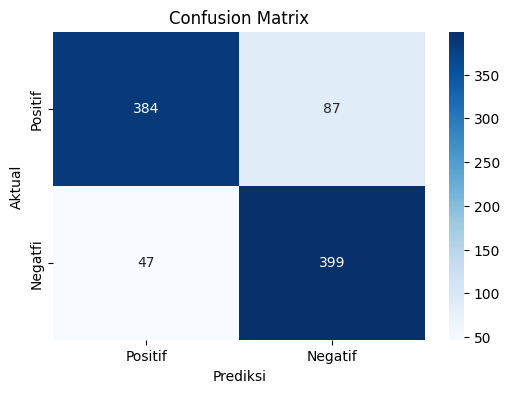

In [ ]:
val_label_df = tokenized_df["validation"]["label"]
# Confusion Matrix
cm = confusion_matrix(val_label_df, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Positif", "Negatif"], yticklabels=["Positif", "Negatfi"])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Classification Report
print(classification_report(val_label_df, y_pred, target_names=["Positif", "Negatif"]))

              precision    recall  f1-score   support

     Positif       0.89      0.82      0.85       471
     Negatif       0.82      0.89      0.86       446

    accuracy                           0.85       917
   macro avg       0.86      0.85      0.85       917
weighted avg       0.86      0.85      0.85       917



In [ ]:
eval_result = trainer.evaluate()
print("Evaluation results: ", eval_result)

Evaluation results:  {'eval_loss': 0.39145439863204956, 'eval_Accuracy': 0.84, 'eval_AUC': 0.913, 'eval_runtime': 3.9744, 'eval_samples_per_second': 153.987, 'eval_steps_per_second': 7.8, 'epoch': 5.0}


In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
positive_text = " ".join(result_df[result_df['predictions'] == 1]['cleaned'])
negative_text = " ".join(result_df[result_df['predictions'] == 0]['cleaned'])

anies_stopwords = {'pk', 'pak', 'good', 'indonesia', 'Unknown', 'president',
                      'presidential', 'bang', 'mr', 'republic', 'indonesia',
                      'election', 'candidate', 'candidates','park', 'jimin',
                      'inismyname', 'dont', 'gangar', 'anies', 'rasyid',
                      'baswedan', 'will', "s"}
custom_stopwords = STOPWORDS.union(anies_stopwords)
def generate_wordcloud(text, title, title_fontsize=20):
    wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=custom_stopwords).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.title(title, fontsize=title_fontsize)
    plt.axis("off")
    plt.show()


Positive Sentiment Word Cloud


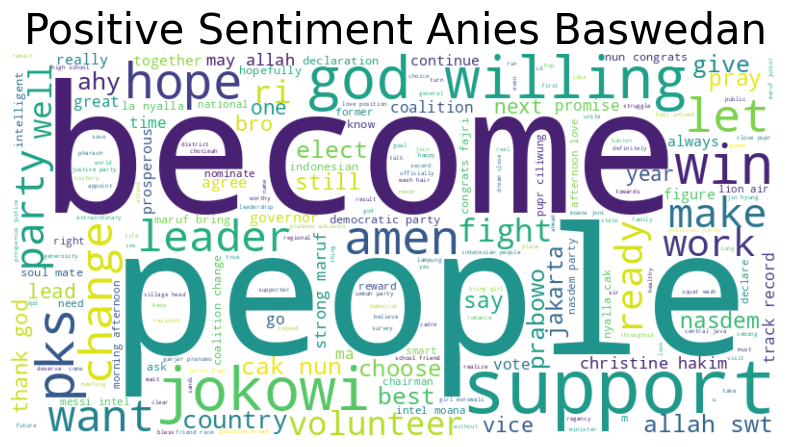

In [ ]:
print("Positive Sentiment Word Cloud")
generate_wordcloud(positive_text, "Positive Sentiment Anies Baswedan", title_fontsize=30)

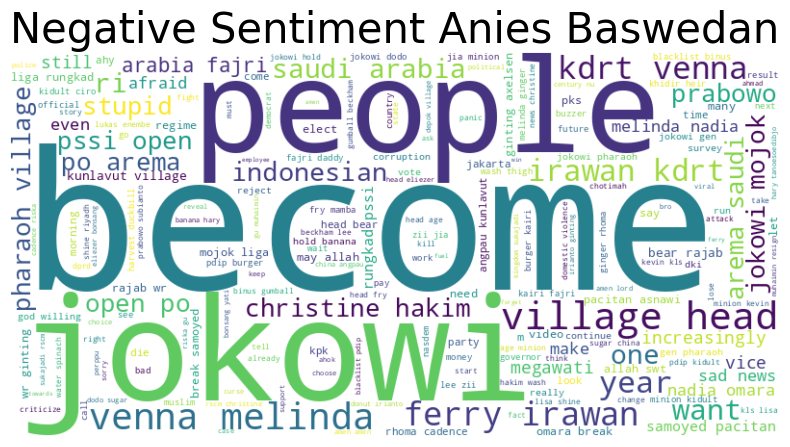

In [ ]:
generate_wordcloud(negative_text, "Negative Sentiment Anies Baswedan", title_fontsize=30)

# BERT FOR PRABOWO

In [ ]:
df_prabowo = pd.read_csv('/content/drive/MyDrive/Semester 7/Artikel Ilmiah/labeled data/Prabowo Subianto.csv')

In [ ]:
df_prabowo = df_prabowo.loc[:, ['Text', 'label']]
df_prabowo = df_prabowo.dropna()
df_prabowo

,Text,label
0,gemira and semeton bali muslims declare suppor...,Positive
1,fahnoor inismyname that's why we support the p...,Negative
2,"this time, jokowi's quota for wrinkles on his ...",Positive
3,"happy birthday to kopassus, may the spirit of ...",Positive
4,gerindra badung party held legislative legisla...,Negative
...,...,...
9995,"sir, if the community always goes down, it wil...",Positive
9996,"young prabowo is really cool, bismillah sir, g...",Positive
9997,"basically, prabowo is great and was chosen as ...",Positive
9998,optimistic about being the best figure in the ...,Positive


In [ ]:
duplicate_rows = df_prabowo[df_prabowo.duplicated()]
duplicate_rows

,Text,label
16,some of the campaign activities of presidentia...,Positive
17,gorontalo netizens pray for minister of defens...,Positive
56,"previously, the chairman of the shura council ...",Negative
72,prabowo subianto discusses leadership philosop...,Positive
81,prabowo subianto discusses leadership philosop...,Positive
...,...,...
9985,prabowo is president,Negative
9986,it is known that gerindra chairman prabowo sub...,Positive
9988,"gerindra, if farmers want to prosper, elect pr...",Positive
9992,"just want to give you a heads up, don't get ex...",Positive


In [ ]:
missing_values = df_prabowo.isnull().sum()
missing_values

,0
Text,0
label,0


In [ ]:
# Removing duplicates

df_prabowo = df_prabowo.drop_duplicates()
df_prabowo['Text'] = df_prabowo['Text'].astype(str)
stop_words = set(stopwords.words('english'))
print(stop_words)
df_prabowo['Text'] = df_prabowo['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


df_prabowo['new_text'] = df_prabowo['Text'].apply(tokenizer_nltk.tokenize)
df_prabowo['new_text'] = df_prabowo['new_text'].apply(convert_list_to_string)
df_prabowo


{'against', "didn't", 'it', 'itself', 'yourself', 'didn', 'did', 'were', 'on', 'just', 'mustn', 'we', 'but', 'at', 'where', 'as', 'of', "that'll", 'herself', "you'll", 'does', 'down', 'the', 'other', 'had', 'an', 'aren', 'because', 'has', 'over', "it's", 'll', "hasn't", 'from', 'same', 'have', 'yours', 'through', 'i', 'into', 'now', 'when', "won't", 'nor', 'been', 'more', 'doesn', 'hers', 'then', "needn't", 'd', "you'd", 'so', "you're", 'up', 'y', "don't", 'you', 'under', 'not', 'm', 'myself', "shouldn't", 'here', "isn't", 'and', 'couldn', 'further', "couldn't", 'he', 'there', 'in', 't', 'those', 'his', 'a', 're', 'such', 'after', 'while', 'off', 'she', 'theirs', "aren't", "wouldn't", 'won', 'me', 'below', 'wasn', 'once', "doesn't", "wasn't", 'them', 'will', 'are', 'mightn', 'any', "mightn't", 'who', 'both', 'between', 'most', 'too', 'only', 'be', 'what', "haven't", 'weren', 'her', 'their', 'than', 'should', 'again', 'few', 'hadn', 'do', 'ma', 'hasn', 'out', 'that', 'ain', 'your', 'the

<ipython-input-53-2cc7225a8906>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prabowo['Text'] = df_prabowo['Text'].astype(str)
<ipython-input-53-2cc7225a8906>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prabowo['Text'] = df_prabowo['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
<ipython-input-53-2cc7225a8906>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,Text,label,new_text
0,gemira semeton bali muslims declare support pr...,Positive,gemira semeton bali muslims declare support pr...
1,fahnoor inismyname that's support president,Negative,fahnoor inismyname that s support president
2,"time, jokowi's quota wrinkles face white hair ...",Positive,time jokowi s quota wrinkles face white hair i...
3,"happy birthday kopassus, may spirit patriotism...",Positive,happy birthday kopassus may spirit patriotism ...
4,gerindra badung party held legislative legisla...,Negative,gerindra badung party held legislative legisla...
...,...,...,...
9995,"sir, community always goes down, easier electe...",Positive,sir community always goes down easier elected ...
9996,"young prabowo really cool, bismillah sir, god ...",Positive,young prabowo really cool bismillah sir god wi...
9997,"basically, prabowo great chosen best president...",Positive,basically prabowo great chosen best president ...
9998,optimistic best figure movement lamongan farme...,Positive,optimistic best figure movement lamongan farme...


In [ ]:
# Melakukan lemmatization pada kolom 'new_text' di dataframe df_anies
df_prabowo["new_text"] = df_prabowo["new_text"].apply(lemmatize_sentence)
print(df_prabowo)

# Menyimpan hasilnya kembali ke kolom asli dan menghapus kolom sementara
df_prabowo["Text"] = df_prabowo["new_text"]
df_prabowo = df_prabowo.drop(columns=["new_text"])

# Mengisi nilai kosong dengan 0 (jika ada) dan menyimpan hasilnya sebagai CSV
df_prabowo['Text'] = df_prabowo['Text'].fillna(0)
df_prabowo.to_csv("df_prabowo_new.csv", index=False)
df_prabowo

                                                   Text     label  \
0     gemira semeton bali muslims declare support pr...  Positive   
1           fahnoor inismyname that's support president  Negative   
2     time, jokowi's quota wrinkles face white hair ...  Positive   
3     happy birthday kopassus, may spirit patriotism...  Positive   
4     gerindra badung party held legislative legisla...  Negative   
...                                                 ...       ...   
9995  sir, community always goes down, easier electe...  Positive   
9996  young prabowo really cool, bismillah sir, god ...  Positive   
9997  basically, prabowo great chosen best president...  Positive   
9998  optimistic best figure movement lamongan farme...  Positive   
9999  best presidential candidate, god willing, prabowo  Positive   

                                               new_text  
0     gemira semeton bali muslim declare support pra...  
1           fahnoor inismyname that s support president

<ipython-input-54-90311fc36195>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prabowo["new_text"] = df_prabowo["new_text"].apply(lemmatize_sentence)
<ipython-input-54-90311fc36195>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prabowo["Text"] = df_prabowo["new_text"]


,Text,label
0,gemira semeton bali muslim declare support pra...,Positive
1,fahnoor inismyname that s support president,Negative
2,time jokowi s quota wrinkle face white hair id...,Positive
3,happy birthday kopassus may spirit patriotism ...,Positive
4,gerindra badung party hold legislative legisla...,Negative
...,...,...
9995,sir community always go down easier elect pres...,Positive
9996,young prabowo really cool bismillah sir god wi...,Positive
9997,basically prabowo great choose best president ...,Positive
9998,optimistic best figure movement lamongan farme...,Positive


In [ ]:
df_prabowo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6780 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    6780 non-null   object
 1   label   6780 non-null   object
dtypes: object(2)
memory usage: 158.9+ KB


In [ ]:
df_prabowo['label'] = df_prabowo['label'].map({'Positive':1, 'Negative':0})
df_prabowo['label'].value_counts()

,count
label,
1,5019
0,1761


In [ ]:
df_prabowo

,Text,label
0,gemira semeton bali muslim declare support pra...,1
1,fahnoor inismyname that s support president,0
2,time jokowi s quota wrinkle face white hair id...,1
3,happy birthday kopassus may spirit patriotism ...,1
4,gerindra badung party hold legislative legisla...,0
...,...,...
9995,sir community always go down easier elect pres...,1
9996,young prabowo really cool bismillah sir god wi...,1
9997,basically prabowo great choose best president ...,1
9998,optimistic best figure movement lamongan farme...,1


In [ ]:
X_prab = df_prabowo['Text'].values.reshape(-1,1)
y_prab = df_prabowo['label']

In [ ]:
X_prab, y_prab = undersampler.fit_resample(X_prab, y_prab)

In [ ]:
print("The distribution after undersampling:")
print(pd.Series(y_prab).value_counts())

The distribution after undersampling:
label
0    1761
1    1761
Name: count, dtype: int64


In [ ]:
df_undersampled_prab = pd.DataFrame(X_prab, columns=['Text'])
df_undersampled_prab['label'] = y_prab
df_undersampled_prab

,Text,label
0,fahnoor inismyname that s support president,0
1,gerindra badung party hold legislative legisla...,0
2,prabowo president cebong kampret retires,0
3,thank god president indonesia one unite nation...,0
4,amien rais vote prabowo subianto anies basweda...,0
...,...,...
3517,never mind worry pray pak prabowo steadfast in...,1
3518,meliala uniform dharma ganesa ri s lead almost...,1
3519,thank fighter kesira gerindra prabowo president,1
3520,rt also emphasize office inaugurate office win...,1


In [ ]:
df_shuffled_prab = df_undersampled_prab.sample(frac=1)
df_shuffled_prab

,Text,label
2903,chotimah self aware really love country join s...,1
3207,trust prabowo president prabowo subianto win f...,1
1733,mr prabowo subianto president republic indones...,0
3482,anies baswedan survey regard presidential cand...,1
1196,normal government hater carry brain think prab...,0
...,...,...
2042,meanwhile musra forum hold jokowi volunteer ga...,1
667,worker support pak gangar become president mar...,0
870,mr prabowow s electability arci s version,0
1874,prabowo president leader wise,1


In [ ]:
train_size_prab = int(train_frac * len(df_shuffled_prab))
valid_size_prab = int(valid_frac * len(df_shuffled_prab))

train_prab = df_shuffled_prab[:train_size_prab]
valid_prab = df_shuffled_prab[train_size_prab:train_size_prab+valid_size_prab]
test_prab = df_shuffled_prab[train_size_prab+valid_size_prab:]

In [ ]:
train_prab['label'].value_counts()

,count
label,
1,1326
0,1315


In [ ]:
# Convert the Pandas Dataframes back to Hugging Face Datasets
train_dataset_prab = Dataset.from_pandas(train_prab)
valid_dataset_prab = Dataset.from_pandas(valid_prab)
test_dataset_prab = Dataset.from_pandas(test_prab)

# Create a DatasetDict
dataset_prab = DatasetDict({
    'train': train_dataset_prab,
    'validation': valid_dataset_prab,
    'test': test_dataset_prab
})

In [ ]:
dataset_prab

DatasetDict({
    train: Dataset({
        features: ['Text', 'label', '__index_level_0__'],
        num_rows: 2641
    })
    validation: Dataset({
        features: ['Text', 'label', '__index_level_0__'],
        num_rows: 528
    })
    test: Dataset({
        features: ['Text', 'label', '__index_level_0__'],
        num_rows: 353
    })
})

In [ ]:
tokenized_prab = dataset_prab.map(preprocess_function, batched=True)

Map:   0%|          | 0/2641 [00:00<?, ? examples/s]

Map:   0%|          | 0/528 [00:00<?, ? examples/s]

Map:   0%|          | 0/353 [00:00<?, ? examples/s]

In [ ]:

trainer_prab = Trainer(model=model,
    args=training_args,
    train_dataset=tokenized_prab["train"],
    eval_dataset=tokenized_prab["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics)
trainer_prab.train()

Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,0.393400,0.367550,0.847000,0.923000
2,0.248900,0.372289,0.864000,0.927000
3,0.163500,0.516875,0.850000,0.903000
4,0.120100,0.585011,0.853000,0.897000
5,0.080700,0.642016,0.850000,0.899000


TrainOutput(global_step=665, training_loss=0.20131437975661198, metrics={'train_runtime': 337.6181, 'train_samples_per_second': 39.112, 'train_steps_per_second': 1.97, 'total_flos': 868595371507200.0, 'train_loss': 0.20131437975661198, 'epoch': 5.0})

In [ ]:
model.save_pretrained("bert-sentiment-analysis-prab")
tokenizer.save_pretrained("bert-sentiment-analysis-classifier-prab")

('bert-sentiment-analysis-classifier-prab/tokenizer_config.json',
 'bert-sentiment-analysis-classifier-prab/special_tokens_map.json',
 'bert-sentiment-analysis-classifier-prab/vocab.txt',
 'bert-sentiment-analysis-classifier-prab/added_tokens.json',
 'bert-sentiment-analysis-classifier-prab/tokenizer.json')

In [ ]:
y_prab = tokenized_prab["test"]["label"] #get the true label from the test dataset

In [ ]:
# Predict the validation dataset
predictions_prab = trainer_prab.predict(tokenized_prab["validation"])
y_pred_prab = predictions_prab.predictions.argmax(axis=1)

In [ ]:
val_cleaned_prab = tokenized_prab["validation"]["Text"]
result_prab = pd.DataFrame({
    'cleaned': val_cleaned_prab,
    'label': predictions_prab.label_ids,
    'predictions': y_pred_prab
})
display(result_prab)

,cleaned,label,predictions
0,latifah refuse vote ani choose pak prabowo pak...,0,0
1,dangerous figure many solution prabowo subiant...,0,0
2,ready support mr prabowo subianto president re...,1,1
3,kesira gerindra always provide light hope peop...,1,1
4,want outdone mother bondowoso also support pra...,1,1
...,...,...,...
523,fahnoor s name basically prabowo president,0,0
524,seem like pak prabowo fail become president el...,0,0
525,please survey institute start survey potential...,0,0
526,together market trader member papera fully sup...,1,1


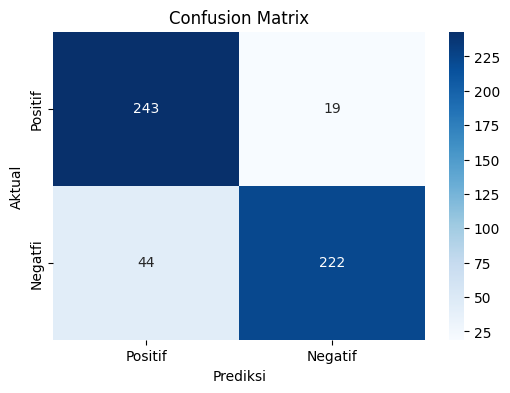

In [ ]:
val_label_prab = tokenized_prab["validation"]["label"]
# Confusion Matrix
cm = confusion_matrix(val_label_prab, y_pred_prab)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Positif", "Negatif"], yticklabels=["Positif", "Negatfi"])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Classification Report
print(classification_report(val_label_prab, y_pred_prab, target_names=["Positif", "Negatif"]))

              precision    recall  f1-score   support

     Positif       0.85      0.93      0.89       262
     Negatif       0.92      0.83      0.88       266

    accuracy                           0.88       528
   macro avg       0.88      0.88      0.88       528
weighted avg       0.88      0.88      0.88       528



In [ ]:
eval_result_prab = trainer_prab.evaluate()
print("Evaluation results: ", eval_result_prab)

Evaluation results:  {'eval_loss': 0.3675497770309448, 'eval_Accuracy': 0.847, 'eval_AUC': 0.923, 'eval_runtime': 2.2268, 'eval_samples_per_second': 158.524, 'eval_steps_per_second': 8.083, 'epoch': 5.0}


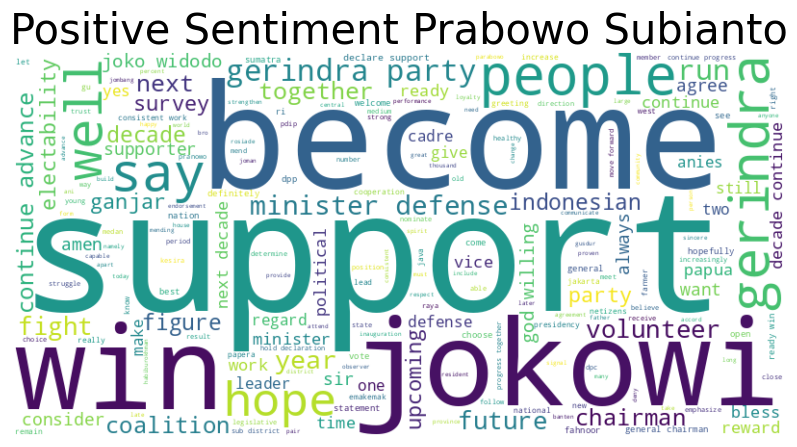

In [ ]:

positive_text_prab = " ".join(result_prab[result_prab['predictions'] == 1]['cleaned'])
negative_text_prab = " ".join(result_prab[result_prab['predictions'] == 0]['cleaned'])

prabowo_stopwords = {'pk', 'pak', 'good', 'indonesia', 'Unknown', 'president',
                      'presidential', 'bang', 'mr', 'republic', 'indonesia',
                      'election', 'candidate', 'candidates','park', 'jimin',
                      'inismyname', 'dont', 'gangar', 'prabowo', 'prabowos',
                     'subianto', 'subiantos', 's'}
custom_stopwords = STOPWORDS.union(prabowo_stopwords)


generate_wordcloud(positive_text_prab, "Positive Sentiment Prabowo Subianto", title_fontsize=30)

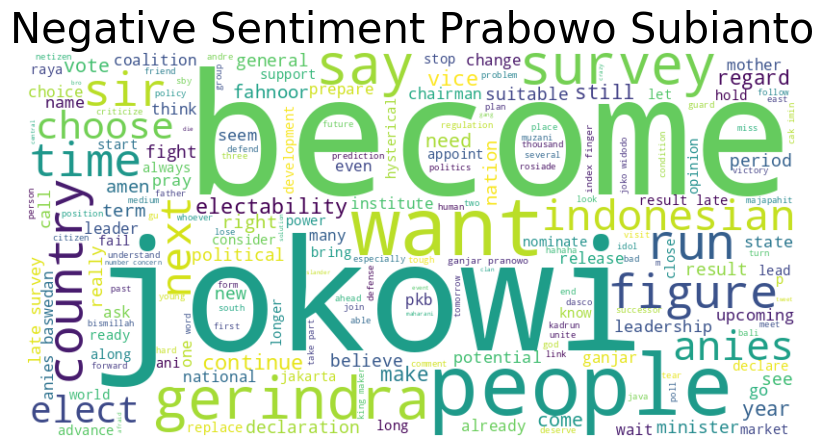

In [ ]:
generate_wordcloud(negative_text_prab, "Negative Sentiment Prabowo Subianto", title_fontsize=30)

# BERT FOR GANJAR

In [ ]:
df_ganjar = pd.read_csv('/content/drive/MyDrive/Semester 7/Artikel Ilmiah/labeled data/Ganjar Pranowo.csv')

In [ ]:
df_ganjar = df_ganjar.loc[:, ['Text', 'label']]
df_ganjar = df_ganjar.dropna()
df_ganjar

,Text,label
0,"ganjar is getting more and more support, now s...",Positive
1,ojoo lali yooo who is smart chooses pranowo's ...,Positive
2,smart people support and reward pranowo well,Positive
3,we believe that pranowo's reward is a gift fro...,Positive
4,intelligent people support and reward pranowo ...,Positive
...,...,...
9995,rt ganjaristdltras ganjarist deltras east java...,Positive
9996,meaning reward pranowo the president,Positive
9997,more and more people are ready to support ganj...,Positive
9998,rt ganjaristdltras ganjarist deltras east java...,Positive


In [ ]:
duplicate_rows = df_ganjar[df_ganjar.duplicated()]
duplicate_rows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2026 entries, 12 to 9998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2026 non-null   object
 1   label   2026 non-null   object
dtypes: object(2)
memory usage: 47.5+ KB


In [ ]:
# Removing duplicates

df_ganjar = df_ganjar.drop_duplicates()
df_ganjar['Text'] = df_ganjar['Text'].astype(str)
stop_words = set(stopwords.words('english'))
print(stop_words)
df_ganjar['Text'] = df_ganjar['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


df_ganjar['new_text'] = df_ganjar['Text'].apply(tokenizer_nltk.tokenize)
df_ganjar['new_text'] = df_ganjar['new_text'].apply(convert_list_to_string)
df_ganjar


{'against', "didn't", 'it', 'itself', 'yourself', 'didn', 'did', 'were', 'on', 'just', 'mustn', 'we', 'but', 'at', 'where', 'as', 'of', "that'll", 'herself', "you'll", 'does', 'down', 'the', 'other', 'had', 'an', 'aren', 'because', 'has', 'over', "it's", 'll', "hasn't", 'from', 'same', 'have', 'yours', 'through', 'i', 'into', 'now', 'when', "won't", 'nor', 'been', 'more', 'doesn', 'hers', 'then', "needn't", 'd', "you'd", 'so', "you're", 'up', 'y', "don't", 'you', 'under', 'not', 'm', 'myself', "shouldn't", 'here', "isn't", 'and', 'couldn', 'further', "couldn't", 'he', 'there', 'in', 't', 'those', 'his', 'a', 're', 'such', 'after', 'while', 'off', 'she', 'theirs', "aren't", "wouldn't", 'won', 'me', 'below', 'wasn', 'once', "doesn't", "wasn't", 'them', 'will', 'are', 'mightn', 'any', "mightn't", 'who', 'both', 'between', 'most', 'too', 'only', 'be', 'what', "haven't", 'weren', 'her', 'their', 'than', 'should', 'again', 'few', 'hadn', 'do', 'ma', 'hasn', 'out', 'that', 'ain', 'your', 'the

<ipython-input-84-6847dcad7850>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ganjar['Text'] = df_ganjar['Text'].astype(str)
<ipython-input-84-6847dcad7850>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ganjar['Text'] = df_ganjar['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
<ipython-input-84-6847dcad7850>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,Text,label,new_text
0,"ganjar getting support, support coming city ba...",Positive,ganjar getting support support coming city bat...
1,ojoo lali yooo smart chooses pranowo's reward,Positive,ojoo lali yooo smart chooses pranowo s reward
2,smart people support reward pranowo well,Positive,smart people support reward pranowo well
3,believe pranowo's reward gift allah almighty i...,Positive,believe pranowo s reward gift allah almighty i...
4,intelligent people support reward pranowo well,Positive,intelligent people support reward pranowo well
...,...,...,...
9993,populi center survey ganjar pranowo presidenti...,Positive,populi center survey ganjar pranowo presidenti...
9994,pa ganjar pranowo nex president indonesia,Negative,pa ganjar pranowo nex president indonesia
9996,meaning reward pranowo president,Positive,meaning reward pranowo president
9997,people ready support ganjar run president repu...,Positive,people ready support ganjar run president repu...


In [ ]:
# Melakukan lemmatization pada kolom 'new_text' di dataframe df_anies
df_ganjar["new_text"] = df_ganjar["new_text"].apply(lemmatize_sentence)
print(df_ganjar)

# Menyimpan hasilnya kembali ke kolom asli dan menghapus kolom sementara
df_ganjar["Text"] = df_ganjar["new_text"]
df_ganjar = df_ganjar.drop(columns=["new_text"])

# Mengisi nilai kosong dengan 0 (jika ada) dan menyimpan hasilnya sebagai CSV
df_ganjar['Text'] = df_ganjar['Text'].fillna(0)
df_ganjar.to_csv("df_ganjar_new.csv", index=False)
df_ganjar

                                                   Text     label  \
0     ganjar getting support, support coming city ba...  Positive   
1         ojoo lali yooo smart chooses pranowo's reward  Positive   
2              smart people support reward pranowo well  Positive   
3     believe pranowo's reward gift allah almighty i...  Positive   
4        intelligent people support reward pranowo well  Positive   
...                                                 ...       ...   
9993  populi center survey ganjar pranowo presidenti...  Positive   
9994          pa ganjar pranowo nex president indonesia  Negative   
9996                   meaning reward pranowo president  Positive   
9997  people ready support ganjar run president repu...  Positive   
9999  happy national aviation day october, fly high ...  Positive   

                                               new_text  
0     ganjar get support support come city batu mala...  
1         ojoo lali yooo smart chooses pranowo s reward

<ipython-input-85-36decbcb260a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ganjar["new_text"] = df_ganjar["new_text"].apply(lemmatize_sentence)
<ipython-input-85-36decbcb260a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ganjar["Text"] = df_ganjar["new_text"]


,Text,label
0,ganjar get support support come city batu mala...,Positive
1,ojoo lali yooo smart chooses pranowo s reward,Positive
2,smart people support reward pranowo well,Positive
3,believe pranowo s reward gift allah almighty i...,Positive
4,intelligent people support reward pranowo well,Positive
...,...,...
9993,populi center survey ganjar pranowo presidenti...,Positive
9994,pa ganjar pranowo nex president indonesia,Negative
9996,mean reward pranowo president,Positive
9997,people ready support ganjar run president repu...,Positive


In [ ]:
df_ganjar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7859 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    7859 non-null   object
 1   label   7859 non-null   object
dtypes: object(2)
memory usage: 184.2+ KB


In [ ]:
df_ganjar['label'] = df_ganjar['label'].map({'Positive':1, 'Negative':0})
df_ganjar['label'].value_counts()

,count
label,
1,6215
0,1644


In [ ]:
X_gan = df_ganjar['Text'].values.reshape(-1,1)
y_gan = df_ganjar['label']

In [ ]:
X_gan, y_gan = undersampler.fit_resample(X_gan, y_gan)

In [ ]:
y_gan.value_counts()


,count
label,
0,1644
1,1644


In [ ]:
df_undersampled_gan = pd.DataFrame(X_gan, columns=['Text'])
df_undersampled_gan['label'] = y_gan
df_undersampled_gan

,Text,label
0,sorry that s pak jokowi s business i m take pa...,0
1,fahnoor inismyname month ramadhan let s pray b...,0
2,type student wait break fast,0
3,chotimah support punishment palestinian president,0
4,chotimah ganjar pranowo win anies baswedan rem...,0
...,...,...
3283,governor central java reward pranowo control e...,1
3284,happy birthday den gangar hope live long see a...,1
3285,ganjar pranowo volunteer member srikandi ganja...,1
3286,central java need disband give up close rank s...,1


In [ ]:
df_shuffled_gan = df_undersampled_gan.sample(frac=1)
df_shuffled_gan

,Text,label
119,social service assistance light badminton cour...,0
2519,continue enthusiastic support mr gangar pranow...,1
975,achmadi ganjar still choice guasi anies frauds...,0
921,pak ganjar president pranowo,0
668,collaborate stakeholder central java prepare n...,0
...,...,...
2668,hope mr ganjar become president year pray,1
1191,moreover president kadrun s reward mass suicide,0
190,gather bangkalan regency sholawat ar ridlwaniy...,0
515,ganjar pranowo s electability presidential can...,0


In [ ]:
train_size_gan = int(train_frac * len(df_shuffled_gan))
valid_size_gan = int(valid_frac * len(df_shuffled_gan))

train_gan = df_shuffled_gan[:train_size_gan]
valid_gan = df_shuffled_gan[train_size_gan:train_size_gan+valid_size_gan]
test_gan = df_shuffled_gan[train_size_gan+valid_size_gan:]

In [ ]:
train_gan['label'].value_counts()

,count
label,
1,1241
0,1225


In [ ]:
# Convert the Pandas Dataframes back to Hugging Face Datasets
train_dataset_gan = Dataset.from_pandas(train_gan)
valid_dataset_gan = Dataset.from_pandas(valid_gan)
test_dataset_gan = Dataset.from_pandas(test_gan)

# Create a DatasetDict
dataset_gan = DatasetDict({
    'train': train_dataset_gan,
    'validation': valid_dataset_gan,
    'test': test_dataset_gan
})
dataset_gan

DatasetDict({
    train: Dataset({
        features: ['Text', 'label', '__index_level_0__'],
        num_rows: 2466
    })
    validation: Dataset({
        features: ['Text', 'label', '__index_level_0__'],
        num_rows: 493
    })
    test: Dataset({
        features: ['Text', 'label', '__index_level_0__'],
        num_rows: 329
    })
})

In [ ]:
tokenized_gan = dataset_gan.map(preprocess_function, batched=True)

Map:   0%|          | 0/2466 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Map:   0%|          | 0/329 [00:00<?, ? examples/s]

In [ ]:

trainer_gan = Trainer(model=model,
    args=training_args,
    train_dataset=tokenized_gan["train"],
    eval_dataset=tokenized_gan["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics)
trainer_gan.train()

Epoch,Training Loss,Validation Loss,Accuracy,Auc
1,0.351900,0.290441,0.869000,0.945000
2,0.233600,0.336662,0.869000,0.939000
3,0.165600,0.331022,0.884000,0.947000
4,0.110400,0.446732,0.884000,0.941000
5,0.080300,0.465439,0.894000,0.943000


TrainOutput(global_step=620, training_loss=0.18837698659589214, metrics={'train_runtime': 334.4956, 'train_samples_per_second': 36.861, 'train_steps_per_second': 1.854, 'total_flos': 811039828147200.0, 'train_loss': 0.18837698659589214, 'epoch': 5.0})

In [ ]:
model.save_pretrained("bert-sentiment-analysis-gan")
tokenizer.save_pretrained("bert-sentiment-analysis-classifier-gan")

('bert-sentiment-analysis-classifier-gan/tokenizer_config.json',
 'bert-sentiment-analysis-classifier-gan/special_tokens_map.json',
 'bert-sentiment-analysis-classifier-gan/vocab.txt',
 'bert-sentiment-analysis-classifier-gan/added_tokens.json',
 'bert-sentiment-analysis-classifier-gan/tokenizer.json')

In [ ]:
# Predict the validation dataset
predictions_gan = trainer_gan.predict(tokenized_gan["validation"])
y_pred_gan = predictions_gan.predictions.argmax(axis=1)

In [ ]:
val_cleaned_gan = tokenized_gan["validation"]["Text"]
result_gan = pd.DataFrame({
    'cleaned': val_cleaned_gan,
    'label': predictions_gan.label_ids,
    'predictions': y_pred_gan
})
display(result_gan)

,cleaned,label,predictions
0,main director coffee shop hendri satrio remind...,1,1
1,east java pak gangar rakyat suitable president...,0,0
2,i javanese suggestion president come outside j...,0,1
3,worthy president republic indonesia period ani...,1,1
4,discourse prabowo ganjar s duet resurface inti...,0,0
...,...,...,...
488,support reward become president,1,1
489,hisnu s declaration presidential retribution e...,0,0
490,mr gangar always mr president s heart definitely,1,1
491,kemantan agung village warm water mak ganjar s...,1,1


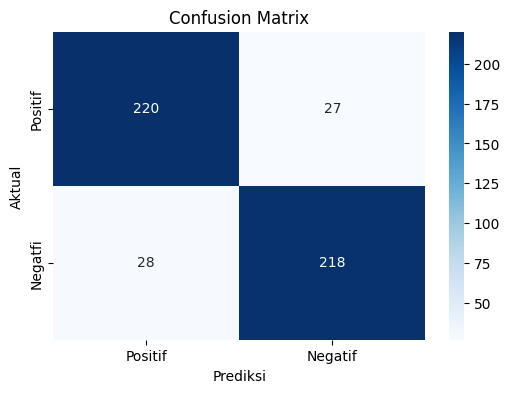

In [ ]:
val_label_gan = tokenized_gan["validation"]["label"]
# Confusion Matrix
cm = confusion_matrix(val_label_gan, y_pred_gan)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Positif", "Negatif"], yticklabels=["Positif", "Negatfi"])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Classification Report
print(classification_report(val_label_gan, y_pred_gan, target_names=["Positif", "Negatif"]))

              precision    recall  f1-score   support

     Positif       0.89      0.89      0.89       247
     Negatif       0.89      0.89      0.89       246

    accuracy                           0.89       493
   macro avg       0.89      0.89      0.89       493
weighted avg       0.89      0.89      0.89       493



In [ ]:
eval_result_gan = trainer_gan.evaluate()
print("Evaluation results: ", eval_result_gan)

Evaluation results:  {'eval_loss': 0.29044121503829956, 'eval_Accuracy': 0.869, 'eval_AUC': 0.945, 'eval_runtime': 2.132, 'eval_samples_per_second': 154.318, 'eval_steps_per_second': 7.974, 'epoch': 5.0}


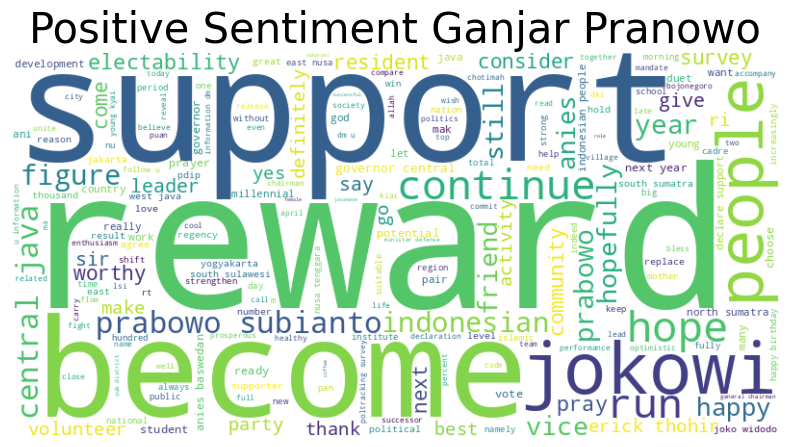

In [ ]:
positive_text_gan = " ".join(result_gan[result_gan['predictions'] == 1]['cleaned'])
negative_text_gan = " ".join(result_gan[result_gan['predictions'] == 0]['cleaned'])

ganjar_stopwords = {'pk', 'pak', 'good', 'indonesia', 'Unknown', 'president',
                      'presidential', 'bang', 'mr', 'republic', 'indonesia',
                      'election', 'candidate', 'candidates','park', 'jimin',
                      'inismyname', 'dont', 'gangar', 'ganjar', 'pranowo',
                     'pranowos', 's'}
custom_stopwords = STOPWORDS.union(ganjar_stopwords)


generate_wordcloud(positive_text_gan, "Positive Sentiment Ganjar Pranowo", title_fontsize=30)

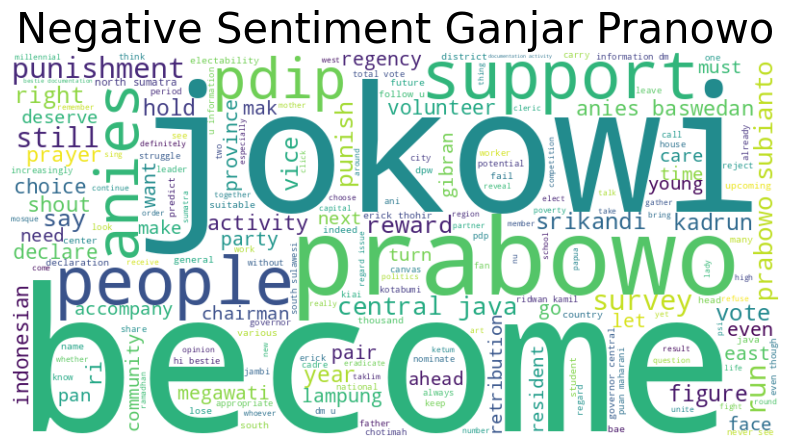

In [ ]:
generate_wordcloud(negative_text_gan, "Negative Sentiment Ganjar Pranowo", title_fontsize=30)